# Supervised Learning
## Regression Algoritms
### Project developed for the Artificial Inteligence Course (IART)

### Introduction
> This notebook aims to display and clarify our 
> approach towards the implementation of regression models.

In [872]:
import math
import numpy as np
import pandas as pd
from matplotlib import style
import matplotlib.pyplot as plt
from sklearn.svm import SVR
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer 
from sklearn.model_selection import cross_validate, train_test_split
from sklearn import preprocessing, linear_model, neighbors

from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_predict

from datetime import datetime, timedelta
from matplotlib.dates import DateFormatter
import matplotlib.dates as mdates


In [873]:
# Reads CVS file to Data Frame
data = pd.read_csv('Global_Mobility_Report.csv')
country = 'US'
data = data.loc[(data.country == country)]
data = data.reset_index(drop=True)

In [874]:
#drop_first= True takes care of Dummy Variable Trap
data = data.drop(columns = ['country','iso'])
# data = pd.get_dummies(data,drop_first=True,columns=["iso","country" ])
data

,date,grocery_pharmacy,parks,residential,retail_recreation,transit_stations,workplaces,total_cases,fatalities,population
0,2/23/2020,3.124,22.982,-0.823,6.813,4.992,2.238,0,0,329064917
1,2/24/2020,0.717,9.233,0.040,1.709,1.285,2.776,0,0,329064917
2,2/25/2020,1.222,9.106,-0.138,4.031,2.155,1.899,0,0,329064917
3,2/26/2020,2.464,5.209,-0.630,7.340,3.498,2.198,0,0,329064917
4,2/27/2020,3.429,12.251,-0.459,7.503,4.013,1.834,0,0,329064917
5,2/28/2020,3.392,9.685,-1.284,7.996,5.340,2.428,0,0,329064917
6,2/29/2020,7.349,20.717,-1.858,11.518,7.367,4.403,0,0,329064917
7,3/1/2020,8.816,17.755,-1.490,12.864,6.691,2.954,0,0,329064917
8,3/2/2020,6.123,10.253,-0.571,7.283,1.694,2.979,0,0,329064917
9,3/3/2020,9.870,20.048,-0.914,10.780,2.976,2.024,0,0,329064917


In [875]:
# Calculates daily percentual changes in number of fatalities
data['fatalities_percent_change'] = pd.Series([])

for i in range(0,len(data['fatalities'])):
    if i != 0 and data['fatalities'][i-1] != 0:
        data['fatalities_percent_change'][i]= (data['fatalities'][i] - data['fatalities'][i-1]) * 100 /data['fatalities'][i-1]
    else:data['fatalities_percent_change'][i] = 0

# Calculates daily percentual changes in number of cases
data['cases_percent_change'] = pd.Series([])
for i in range(0,len(data['total_cases'])):
    if i != 0 and data['total_cases'][i-1] != 0:
        data['cases_percent_change'][i]= (data['total_cases'][i] - data['total_cases'][i-1]) * 100 /data['total_cases'][i-1]
    else:data['cases_percent_change'][i] = 0

# Calculates cases of covid per million inhabitants
data['cases_per_million'] = pd.Series([])
for i in range(0,len(data['total_cases'])):
    millions = data['population'][i]/1000000
    data['cases_per_million'][i]= data['total_cases'][i]/millions

# Drop unnecessary columns from data set
data = data.drop(columns = ['fatalities'])
data = data.drop(columns = ['total_cases'])
data = data.drop(columns = ['population'])

data

,date,grocery_pharmacy,parks,residential,retail_recreation,transit_stations,workplaces,fatalities_percent_change,cases_percent_change,cases_per_million
0,2/23/2020,3.124,22.982,-0.823,6.813,4.992,2.238,0.000000,0.000000,0.000000
1,2/24/2020,0.717,9.233,0.040,1.709,1.285,2.776,0.000000,0.000000,0.000000
2,2/25/2020,1.222,9.106,-0.138,4.031,2.155,1.899,0.000000,0.000000,0.000000
3,2/26/2020,2.464,5.209,-0.630,7.340,3.498,2.198,0.000000,0.000000,0.000000
4,2/27/2020,3.429,12.251,-0.459,7.503,4.013,1.834,0.000000,0.000000,0.000000
5,2/28/2020,3.392,9.685,-1.284,7.996,5.340,2.428,0.000000,0.000000,0.000000
6,2/29/2020,7.349,20.717,-1.858,11.518,7.367,4.403,0.000000,0.000000,0.000000
7,3/1/2020,8.816,17.755,-1.490,12.864,6.691,2.954,0.000000,0.000000,0.000000
8,3/2/2020,6.123,10.253,-0.571,7.283,1.694,2.979,0.000000,0.000000,0.000000
9,3/3/2020,9.870,20.048,-0.914,10.780,2.976,2.024,0.000000,0.000000,0.000000


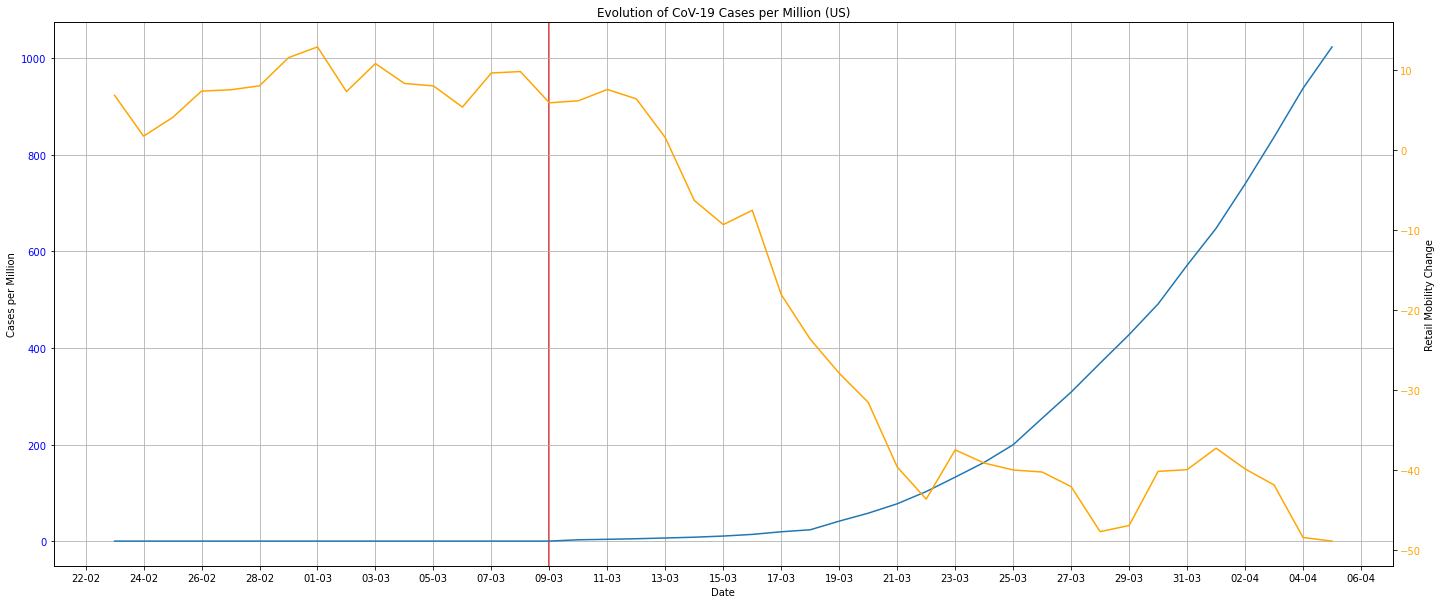

In [876]:
starting_day = pd.to_datetime(data['date'][0])
day_index = 0
for day_index in range(0,len(data['cases_per_million'])):
    if data['cases_per_million'][day_index] != 0:
        starting_day = pd.to_datetime(data['date'][day_index -1])
        break


dates = data['date']
date_format = [pd.to_datetime(d) for d in dates]

_, ax = plt.subplots(figsize=(24, 10))
ax.grid()
ax.plot(date_format, data['cases_per_million'])
ax.set(xlabel="Date", ylabel='Cases per Million', title=("Evolution of CoV-19 Cases per Million (%s)" % (country)))
date_form = DateFormatter("%d-%m")
ax.xaxis.set_major_formatter(date_form)
ax.xaxis.set_major_locator(mdates.DayLocator(interval=2))
ax.axvline(starting_day, c="red", zorder=0)
ax.tick_params(axis='y', labelcolor= "blue")
ax2 = ax.twinx()  
ax2.set_ylabel('Retail Mobility Change')
ax2.plot(date_format, data['retail_recreation'], color = "orange")
ax.xaxis.set_major_formatter(date_form)
ax.xaxis.set_major_locator(mdates.DayLocator(interval=2))
ax2.tick_params(axis='y', labelcolor= "orange")
plt.show()

As we can see from the graph above, when the first cases of CoV-19 were registered, the retail mobility (e.g) dropped considerably. For this reason we will only consider data 

In [877]:
X = data.iloc[day_index:,1:9]
#assuming the last column is the one to be predicted
Y = data.iloc[day_index:,9:]
Y

,cases_per_million
16,2.710711
17,3.689242
18,4.850107
19,6.418186
20,8.077434
21,10.426514
22,13.872643
23,19.306221
24,23.445222
25,41.353542


In [878]:
# Replaces NaN values present in the new columns by 0
X['fatalities_percent_change'] = X['fatalities_percent_change'].replace(np.NaN, 0)
X['cases_percent_change'] = X['cases_percent_change'].replace(np.NaN, 0)
Y['cases_per_million'] = Y['cases_per_million'].replace(np.NaN, 0)

# Fills the empty values taking mean values present in each column
X = X.replace("", np.NaN)
Y = Y.replace("", np.NaN)
imputer = SimpleImputer(missing_values=np.NaN, strategy='mean')
X = imputer.fit_transform(X)
Y = imputer.fit_transform(Y)
Y

array([[   2.71071133],
       [   3.68924166],
       [   4.85010683],
       [   6.41818648],
       [   8.07743355],
       [  10.42651411],
       [  13.87264264],
       [  19.30622097],
       [  23.4452219 ],
       [  41.35354241],
       [  57.81533982],
       [  77.29477889],
       [ 102.60893294],
       [ 132.45410783],
       [ 163.06508907],
       [ 199.65969207],
       [ 254.53640201],
       [ 308.69288931],
       [ 368.65978028],
       [ 427.74842509],
       [ 491.32858487],
       [ 571.37054206],
       [ 647.93902049],
       [ 739.79627552],
       [ 836.99594144],
       [ 938.09149518],
       [1023.84661079]])

In [879]:
# Standardization using Gaussian Normal Distribution
X = preprocessing.scale(X)
print("---------------------------------------------------------\n",X)

---------------------------------------------------------
 [[ 6.92700671e-01  1.71729970e+00 -1.76671981e+00  1.88657117e+00
   1.93374501e+00  1.75714242e+00 -2.03430074e+00 -1.80911634e+00]
 [ 8.68989434e-01  2.32258857e+00 -1.83010487e+00  1.96317994e+00
   1.95872933e+00  1.78033363e+00  3.19475304e-01  7.72299334e-01]
 [ 1.71734104e+00  1.77855586e+00 -1.69930116e+00  1.89938435e+00
   1.71797133e+00  1.67662731e+00 -1.11894339e+00  4.41034341e-01]
 [ 1.93903854e+00  6.74520360e-01 -1.44820989e+00  1.63706556e+00
   1.48763803e+00  1.44162309e+00 -5.92612914e-01  5.02861888e-01]
 [ 1.42844402e+00  5.49533794e-01 -1.40945857e+00  1.21287900e+00
   1.51104991e+00  1.79044261e+00 -8.07332378e-01  3.95803110e-02]
 [ 9.86199468e-01  7.04661091e-01 -1.36825828e+00  1.04965962e+00
   1.31484437e+00  1.45286190e+00 -6.61264715e-01  2.70539370e-01]
 [ 1.62408733e+00  2.74743293e-01 -7.61922562e-01  1.14654240e+00
   8.00423609e-01  6.67869300e-01  8.42536648e-01  5.54403553e-01]
 [ 1.11870

In [880]:
pca = PCA(n_components=2) # Here we can also give the percentage as a paramter to the PCA function as pca = PCA(.95). .95 means that we want to include 95% of the variance. Hence PCA will return the no of components which describe 95% of the variance. However we know from above computation that 2 components are enough so we have passed the 2 components.
principalComponents = pca.fit_transform(X) 
print(pca.explained_variance_ratio_)
principalDf = pd.DataFrame(data = principalComponents) 
principalDf.head(5) # prints the top 5 rows
print(pca.components_)

[0.68247997 0.22296736]
[[ 0.39289409  0.37283452 -0.39404191  0.41568115  0.42553647  0.40800669
  -0.11841312  0.13037019]
 [ 0.13027736  0.07523198  0.0954432  -0.02519027 -0.02923957 -0.06659996
   0.69299011  0.69433292]]


In [881]:
# data['day'] = pd.Series([])
# for i in range(1,len(data['retail_recreation'])):
#     data['day'][i] = i
# data.drop(data.head(16).index, inplace =True)
# for i in range(17,43): #26
#     days.append([i])

# days_pred = []
# for i in range(43,50):
#     days_pred.append([i])

# x = data[['day','retail_recreation','fatalities_percent_change']]
# y = data[['cases_percent_change']]
# days = data[['day']]
# y = y.reset_index(drop=True)
# x = x.reset_index(drop=True)
# days = days.reset_index(drop=True)

# days
# x = X[['retail_and_recreation_percent_change_from_baseline']]
# #assuming the last column is the one to be predicted
# y = Y[['cases_percent_change']]

In [882]:
# # Split data to create a training and testing set
# X_train, X_test, Y_train, Y_test = train_test_split(x,y,test_size= 0.2)
# X_train = X[:20,:]
# Y_train = Y[:20,:]
# X_test = X[20:,:]
# Y_test = Y[20:,:]
# # X = np.array([[1, 2], [3, 4], [1, 2], [3, 4]]) # create an array
# # y = np.array([1, 2, 3, 4]) # Create another array
# kf = KFold(n_splits=10) # Define the split - into 2 folds 
# kf.get_n_splits(X) # returns the number of splitting iterations in the cross-validator
# print(kf) KFold(n_splits=2, random_state=None, shuffle=False)
# # Make cross validated predictions
# predictions = cross_val_predict(kf, X, Y, cv=6)
# plt.scatter(Y, predictions)
# # days_train.reshape(-1, 1)
# days_test.reshape(-1, 1)

#############################################################################
##

# create training and testing vars
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)

# fit a model
lm = linear_model.LinearRegression()
model = lm.fit(X_train, Y_train)
linear_predictions = lm.predict(X)
print("Score:", model.score(X_test, Y_test))

# kf = KFold(n_splits=2)
# kf.get_n_splits(X)
# # print(kf) 
# KFold(n_splits=2, random_state=None, shuffle=True)

# for train_index, test_index in kf.split(X):
#     print("TRAIN:", train_index, "TEST:", test_index)
#     X_train, X_test = X[train_index], X[test_index]
#     Y_train, Y_test = Y[train_index], Y[test_index]

# Necessary imports: 
# from sklearn.model_selection import cross_val_score, cross_val_predict
# from sklearn import metrics

# # Perform 6-fold cross validation
# scores = cross_val_score(model, X, Y, cv=2)
# print("Cross-validated scores:", scores)

# svr_poly = SVR(kernel='poly', C=1e3, degree=1)
svr_poly = SVR(kernel='poly', C=100, gamma='auto', degree=3, epsilon=.1,
               coef0=1)
svr_lin = SVR(kernel='linear', C=100, gamma='auto')
svr_rbf = SVR(kernel='rbf', C=100, gamma=0.1, epsilon=.1)

svr_poly_model = svr_poly.fit(X_train, Y_train)
print("POLY Regression Model Score: %s" % (svr_poly_model.score(X_test, Y_test)))
svr_poly_predictions = svr_poly_model.predict(X)

svr_lin_model = svr_lin.fit(X_train, Y_train)
print("lin Regression Model Score: %s" % (svr_lin_model.score(X_test, Y_test)))
svr_lin_predictions = svr_lin_model.predict(X)

svr_rbf_model = svr_rbf.fit(X_train, Y_train)
print("rbf Regression Model Score: %s" % (svr_rbf_model.score(X_test, Y_test)))
svr_rbf_predictions = svr_rbf_model.predict(X)

##
#############################################################################



Score: 0.5735013310722983
POLY Regression Model Score: 0.7687629032270088
lin Regression Model Score: 0.4691101643497391
rbf Regression Model Score: 0.6210509612650497


In [883]:
# error = max_error(y, y_pred)

# X_test = []
# future_days = 200
# for i in range(starting_date, starting_date + future_days):
#     X_test.append([i])
# y_pred_linear = linear_regr.predict(X_test)

# y_pred_max = []
# y_pred_min = []
# for i in range(0, len(y_pred_linear)):
#     y_pred_max.append(y_pred_linear[i] + error)
#     y_pred_min.append(y_pred_linear[i] - error)

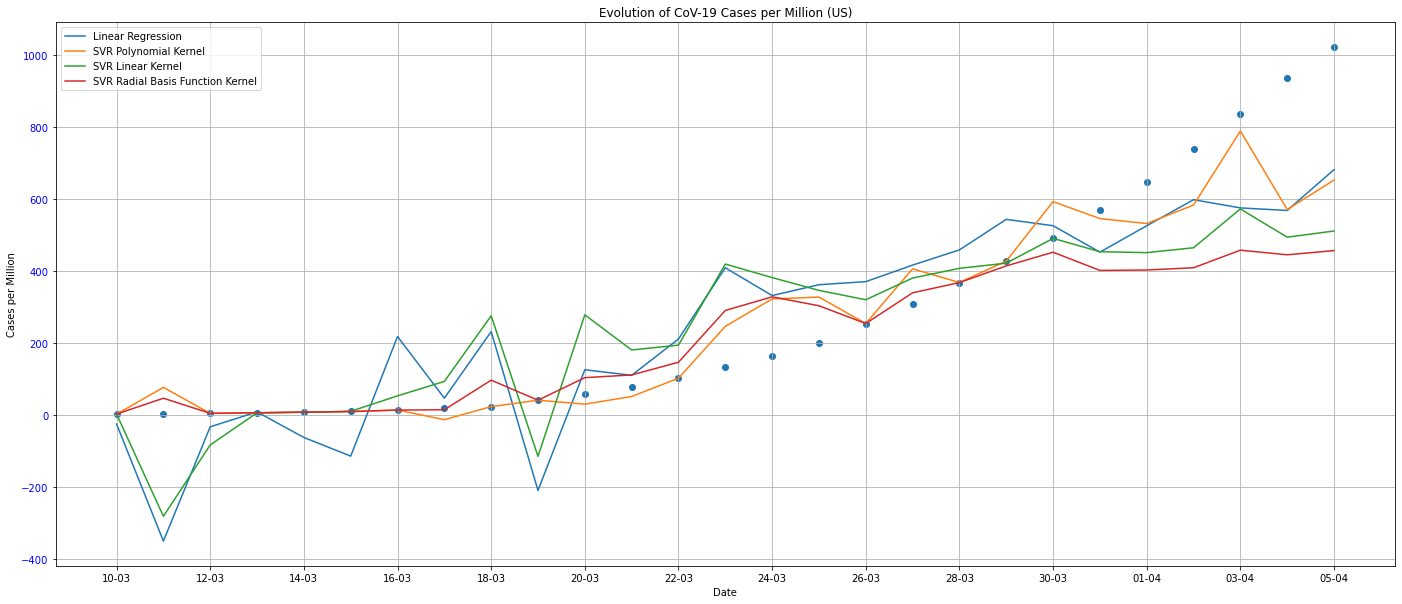

In [884]:
dates = data['date']
date_format = [pd.to_datetime(d) for d in dates]
_, ax = plt.subplots(figsize=(24, 10))
ax.grid()
ax.scatter(date_format[day_index:], data['cases_per_million'][day_index:])
linear_plot, = ax.plot(date_format[day_index:], linear_predictions)
svr_poly_plot, = ax.plot(date_format[day_index:], svr_poly_predictions)
svr_lin_plot, = ax.plot(date_format[day_index:], svr_lin_predictions)
svr_rbf_plot, = ax.plot(date_format[day_index:], svr_rbf_predictions)
ax.legend((linear_plot, svr_poly_plot, svr_lin_plot, svr_rbf_plot), ('Linear Regression', 'SVR Polynomial Kernel','SVR Linear Kernel', 'SVR Radial Basis Function Kernel'), loc='upper left', shadow=False)

ax.set(xlabel="Date", ylabel='Cases per Million', title=("Evolution of CoV-19 Cases per Million (%s)" % (country)))
date_form = DateFormatter("%d-%m")
ax.xaxis.set_major_formatter(date_form)
ax.xaxis.set_major_locator(mdates.DayLocator(interval=2))
ax.tick_params(axis='y', labelcolor= "blue")

KNN Regression Model - Uniform:  0.8199274751040668
KNN Regression Model - Distance:  0.846763126684704


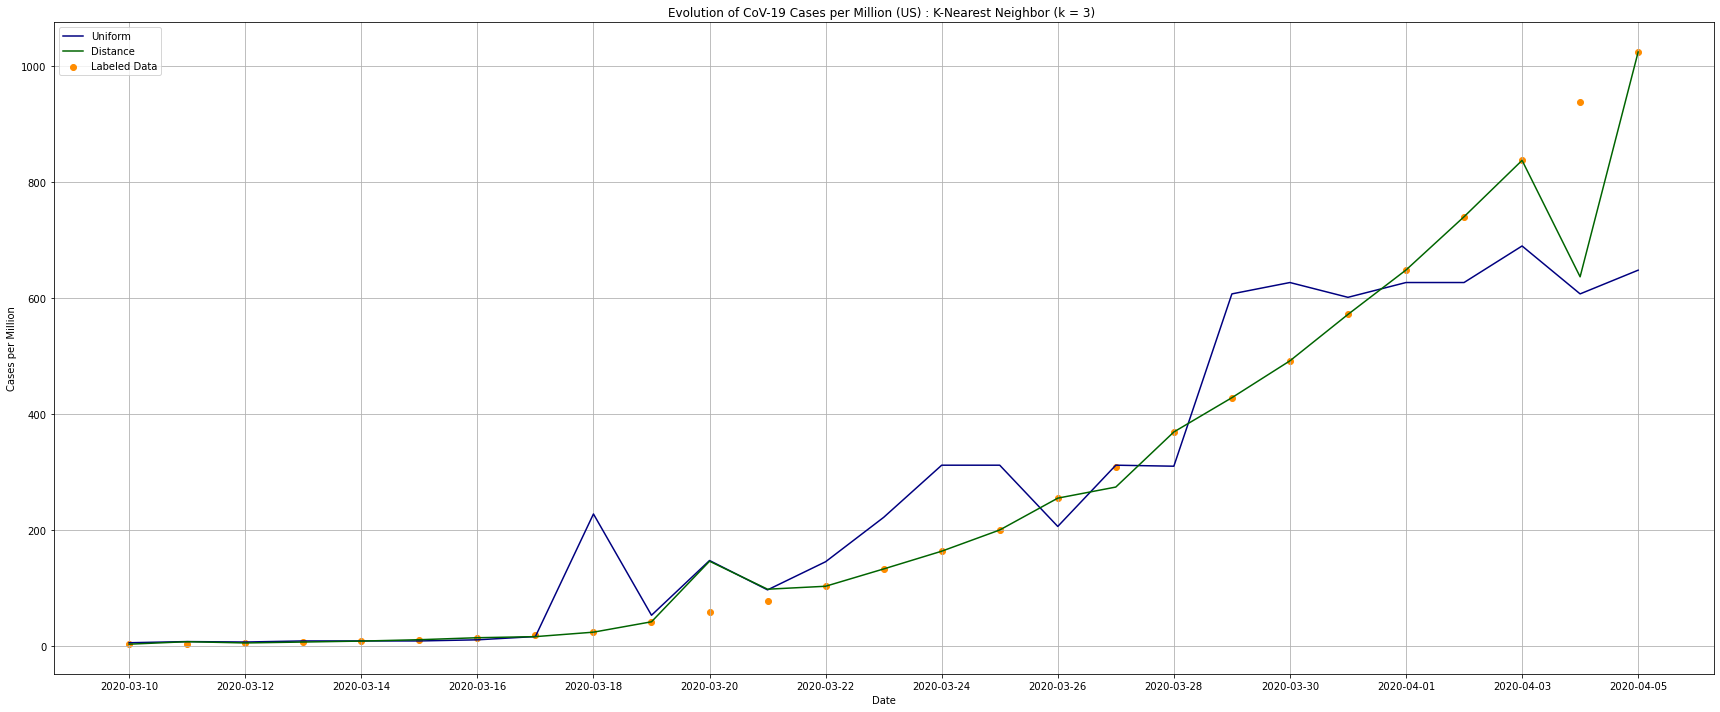

In [885]:
n_neighbors = 3

knn_uniform = neighbors.KNeighborsRegressor(n_neighbors, weights='uniform')
knn_predictions_uniform = knn_uniform.fit(X_train, Y_train).predict(X)
knn_distance = neighbors.KNeighborsRegressor(n_neighbors, weights='distance')
knn_predictions_distance = knn_distance.fit(X_train, Y_train).predict(X)

_, ax = plt.subplots(figsize=(24, 10))
ax.grid()
labeled = ax.scatter(date_format[day_index:], Y, color='darkorange', label='data')
unif, = ax.plot(date_format[day_index:], knn_predictions_uniform, color='navy')
dist, = ax.plot(date_format[day_index:], knn_predictions_distance, color='darkgreen')
ax.legend((unif, dist, labeled), ('Uniform', 'Distance','Labeled Data'), loc='upper left', shadow=False)
ax.set(xlabel="Date", ylabel='Cases per Million', title = "Evolution of CoV-19 Cases per Million (%s) : K-Nearest Neighbor (k = %i) " % (country, n_neighbors))
ax.axis('tight')
print("KNN Regression Model - Uniform:  %s"  % (knn_uniform.score(X_test, Y_test)))
print("KNN Regression Model - Distance:  %s"  % (knn_distance.score(X_test, Y_test)))
plt.tight_layout()
plt.show()

We can see that if the maximum depth of the tree (controlled by the max_depth parameter) is set too high, the decision trees learn too fine details of the training data and learn from the noise, i.e. they overfit.



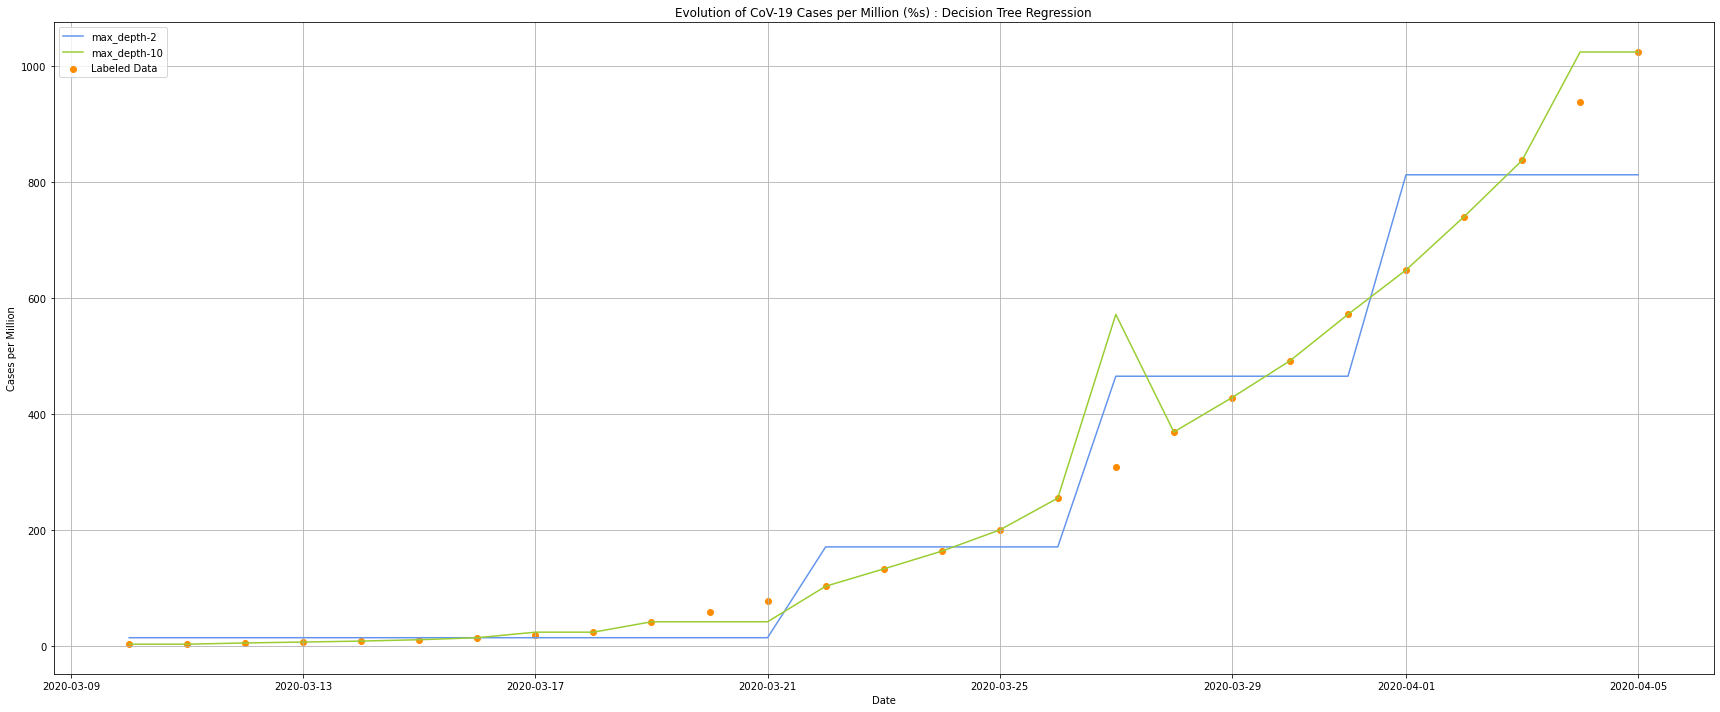

In [886]:

# Import the necessary modules and libraries
import numpy as np
from sklearn.tree import DecisionTreeRegressor
import matplotlib.pyplot as plt

# Fit regression model
regr_1 = DecisionTreeRegressor(max_depth=2)
regr_2 = DecisionTreeRegressor(max_depth=10)
regr_1.fit(X_train, Y_train)
regr_2.fit(X_train, Y_train)

# Predict
y_1 = regr_1.predict(X)
y_2 = regr_2.predict(X)

# Plot the results
_, ax = plt.subplots(figsize=(24, 10))
ax.grid()
labeled = ax.scatter(date_format[day_index:], Y, color='darkorange', label='data')
max_depth2, = ax.plot(date_format[day_index:], y_1, color='cornflowerblue')
max_depth10, = ax.plot(date_format[day_index:], y_2, color='yellowgreen')
ax.legend((max_depth2, max_depth10, labeled), ('max_depth-2', 'max_depth-10','Labeled Data'), loc='upper left', shadow=False)
ax.set(xlabel="Date", ylabel='Cases per Million', title = "Evolution of CoV-19 Cases per Million (%s) : Decision Tree Regression")
plt.tight_layout()
plt.show()

In [887]:
# # Instantiate Linear Regression
# linear_regr = linear_model.LinearRegression()
# linear_regr.fit(X_train, Y_train)
# print("Linear Regression Model Score: %s" % (linear_regr.score(X_test, Y_test)))
# y_pred = linear_regr.predict(X_test)

# plt.figure(figsize=(24, 10))
# plt.grid()
# plt.scatter(days, y)
# plt.plot(X_test['day'], y_pred, color='green', linewidth=2)
# plt.ylabel('cases_percent_change')
# plt.yscale('linear')
# plt.savefig('retail_and_recreation_percent_change_from_baseline_prediction.png')
# plt.show()

In [888]:
# svr_poly = SVR(kernel='poly', C=1e3, degree=2)
# y_poly = svr_poly.fit(days_train, retail_train)
# print("POLY Regression Model Score: %s" % (y_poly.score(days_test, retail_test)))
# y_pred_poly = y_poly.predict(days)
# retail_train

In [889]:
# knn = neighbors.KNeighborsRegressor(3, weights='distance')
# y_ = knn.fit(days_train, retail_train).predict(retail)

NameError: name 'days_train' is not defined

In [890]:
# plt.figure(figsize=(24, 10))
# plt.grid()
# # plot linear regression prediction

# plt.scatter(days, fatal)
# plt.scatter(days, retail)
# # plt.plot(days, y_fatal_pred, color='red', linewidth=2)
# plt.plot(days, y_, color='green', linewidth=2)
# plt.show()

NameError: name 'days' is not defined